# Test notebook

This notebook runs through the calibration and model evaluation steps as used in the publication. We use the following randomized test data:
- *test_meshs.nc*: A hazard dataset with the same format as the used radar data (MESHS=Maximum expected severe hail size). Here with 1 month duration, small spatial extent, and 5 days with an artificial circular hail footprint.
- *test_exp.csv*: An exposure dataset with coordinates and building values with the same format as the data from building insurances in the publication. Here Simply random values on a regular grid.
- *test_dmg.csv*: A table of artificial observed hail damages. Here, including 4 rectangular patches of damages on 4 out of the 5 days with nonzero hazard intensity.

Note that the small number of (randomized) exposure and damage reports and the short consideredtime period of 1 month lead to high uncertainties and such a calibration would **not** be recommended with so little data. The purpose is only to show the required structure of the data and the needed computational steps to perform a calibration as in the publication with a different dataset.

In [2]:
#Load packages
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import datetime as dt
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import ImpactCalc
import scClim as sc
from scClim.constants import UNIT_DICT,CUT_OFF_DICT,INT_RANGE_DICT,INT_LABEL_DICT,W_SIZE_DICT


# Note: if the scClim package is not in the same folder, it can be added
# as follows (the path can be saved in the CLIMADA config file):

# from climada import CONFIG
# sys.path.append(str(CONFIG.local_data.func_dir))
# import scClim as sc

## Step 1: Set constants and load hazard, exposure, and damage data
relevant code from *calibration_main.py*

In [3]:
data_dir = "./test_data"
haz_var = 'MESHS' #Maximum Expected Severe Hail Size
exposure = 'KGV' # "Kantonale Gebäudeversicherung" (data format of cantonal building insurances)

years = [2021]
n_years = 1

#Hazard
paths = data_dir + '/test_meshs.nc'

#set cut_off and intensity_range
unit = UNIT_DICT[haz_var]
cut_off = CUT_OFF_DICT[haz_var]
intensity_range= INT_RANGE_DICT[haz_var]
intensity_label= INT_LABEL_DICT[haz_var]

#windowsize (rolling) in hazard units:
assert(len(np.unique(np.diff(intensity_range[1:])))==1)
stepsize = np.unique(np.diff(intensity_range[1:]))[0]
window_size = W_SIZE_DICT[haz_var]
unit_windowsize = stepsize*window_size

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

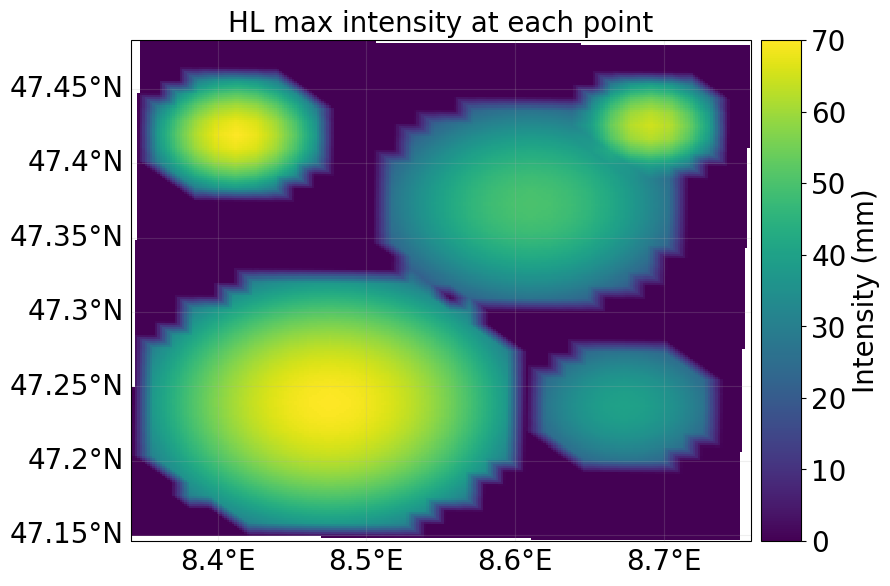

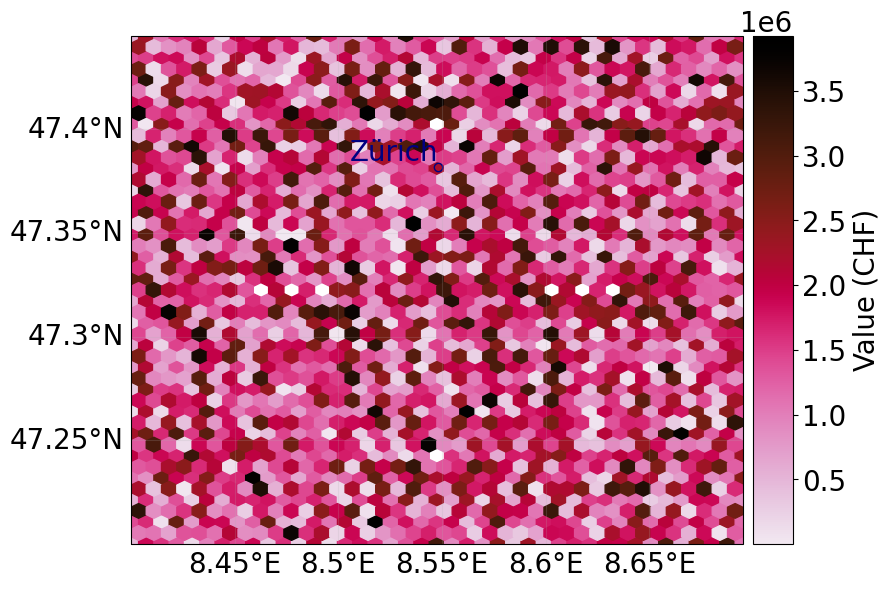

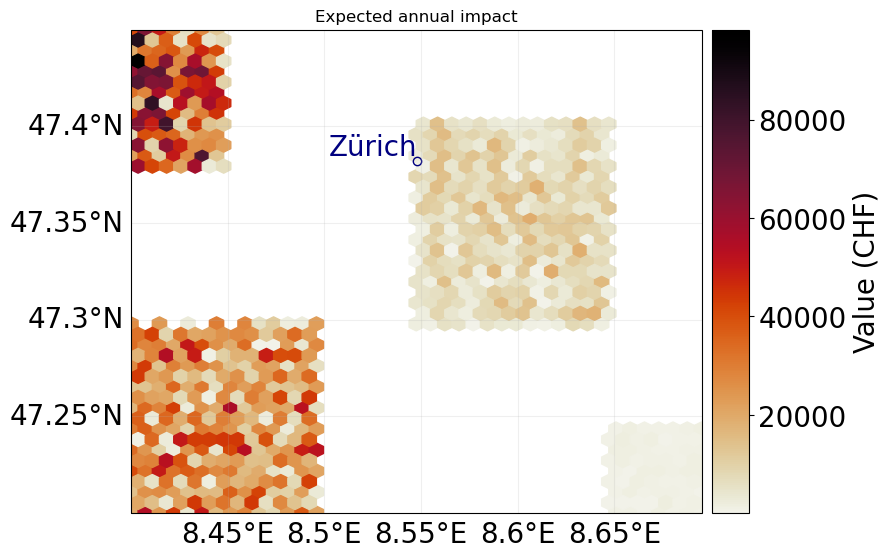

In [4]:
# Create Hazard object
haz = sc.hazard_from_radar(
    paths, extent=[5.8, 10.6, 45.7, 47.9], varname=haz_var)
haz.plot_intensity(0)

# Create Exposure object
exp = sc.read_gvz_exposure(f'{data_dir}/test_exp.csv',
                            crs = 'EPSG:4326')
exp.assign_centroids(haz)
exp.gdf=exp.gdf.rename(columns={'id_col':'VersicherungsID'})
exp.plot_hexbin(gridsize=40)

# Create Impact object
imp_path = f'{data_dir}/test_dmg.csv'
imp_measured = sc.read_gvz_dmg(imp_path, 'KGV',return_type='imp',
                                years=(years[0],years[-1]),
                                baujahr_filter='',index_dmgs=False,
                                crs='EPSG:4326',id_col='id_col')
imp_measured.plot_hexbin_eai_exposure(gridsize=40)

## Step 2: Perform emprirical calibration (See Section 4 of the paper)
relevant code from *calibration_main.py*

In [5]:
# create idendity impact function (to determine dates
# with nonzero hazard intensity over an exposed asset)
imp_fun_set = ImpactFuncSet()
imp_fun_identity = ImpactFunc.from_step_impf((0, 1, max(intensity_range)*2),haz_type='HL')
imp_fun_set.append(imp_fun_identity)

# calculate impact (with identitiy impact function)
imp = ImpactCalc(exp, imp_fun_set, haz).impact(save_mat=True)

#get dates with nonzero modelled impact
dates_modeled_imp = np.array([dt.datetime.fromordinal(d) for d in imp.date[imp.at_event > 0]])

In [7]:
# Perform empirical calibration
calib_tuple = sc.empirical_calibration_per_exposure(hazard_object = haz,
    exposure_object = exp, damages = imp_measured, exposure_type = 'GVZ',
    variable = haz_var,filter_year=None,dates_modeled_imp=dates_modeled_imp,
    roll_window_size=window_size,get_PVA=True)
ds, df_all, ds_roll, ds_roll_cut, values_at_centroid_all, intensity_range = calib_tuple

#make sure zero values are included (not NaN)
values_at_centroid_all['PAA'] = (values_at_centroid_all['n_dmgs']/
                                 values_at_centroid_all['n_exp'])
values_at_centroid_all['MDR'] = (values_at_centroid_all['dmg_val']/
                                 values_at_centroid_all['exp_val'])
#save values_at_centroids to csv
values_at_centroid_all.to_csv(f'{data_dir}/temp/at_centr.csv',index=False)

n_samples=200 #number of bootstrapping samples (1000 in the paper)
out_tuple=sc.bootstrapping(ds, ds_roll,haz_var,n_samples,intensity_range,
                           log_fit=False,cut_off=cut_off,keep_raw_values=True)
ds_boot,ds_boot_roll,ds_boot_roll_cut, fit_data = out_tuple

# Get empirical damage functions
df, df_roll, df_roll_cut, n_dmgs = sc.compute_empirical_damage_functions(
    ds, ds_roll, ds_roll_cut,get_monotonic_fit=False)

# fit Sigmoidal function
y_bounds = [min(intensity_range),max(intensity_range)]
v_tresh_bounds = (0,20) #visually detemined (MDR/PAA is >0 at MESHS=20)
pbounds={'v_thresh': v_tresh_bounds, 'v_half': y_bounds,
         'scale': [df.MDR.max()/10, min(1,df.MDR.max()*10)],
          'power': (3,3)
          }
p,res,impf_emanuel = sc.calib_opt.fit_emanuel_impf_to_emp_data(df,pbounds,plot=False)

2024-01-22 15:56:46,477 - climada.util.coordinates - WARNING - This function has been renamed, use match_coordinates instead.
Optimization terminated successfully.
         Current function value: 0.000068
         Iterations: 198
         Function evaluations: 348
{'v_thresh': 18.298228349535336, 'v_half': 56.7946488159817, 'scale': 0.025812610164563845, 'power': 3.0}


In [8]:
# Fit separate sigmoidal functions for PAA and MDD
pboundsPAA={'v_thresh': v_tresh_bounds, 'v_half': y_bounds,
            'scale': [df_roll.PAA.max()/10, min(1,df.PAA.max()*10)]}
p_PAA,resPAA,impf_emanuelPAA = sc.calib_opt.fit_emanuel_impf_to_emp_data(
    df,pboundsPAA,opt_var='PAA',plot=False)


df_roll.loc[df_roll.MDD==np.inf,'MDD']=np.nan
pboundsMDD={'v_thresh': v_tresh_bounds, 'v_half': y_bounds,
            'scale': [df.MDD.max()/10, df.MDD.max()*5]}
p_MDD,resMDD,impf_emanuelMDD = sc.calib_opt.fit_emanuel_impf_to_emp_data(
    df_roll,pboundsMDD,opt_var='MDD',plot=False)


Optimization terminated successfully.
         Current function value: 0.158218
         Iterations: 69
         Function evaluations: 131
{'v_thresh': 0.0, 'v_half': 48.69128293338812, 'scale': 1.0}
Optimization terminated successfully.
         Current function value: 0.000187
         Iterations: 119
         Function evaluations: 216
{'v_thresh': 4.343469467910686, 'v_half': 39.16167397328579, 'scale': 0.02509572495211096}


In [9]:
# Emanuel fit for every bootstrapped sample (here for MDR only)
df_boot_emanuel = pd.DataFrame(index = intensity_range, dtype=float,
                               columns = [f'b_{i}' for i in range(n_samples)])
for i in range(n_samples):
    df_now = ds_boot.isel(b_sample=i).to_dataframe()
    pNow,resNow,impf_emanuelNow = sc.calib_opt.fit_emanuel_impf_to_emp_data(
        df_now,pbounds,plot=False,verbose=False)
    df_boot_emanuel.loc[impf_emanuelNow.intensity,f'b_{i}']=impf_emanuelNow.mdd

## Step 3: Plot resulting impact function and save as csv
relevant code from *calibration_main.py*

c:\Users\timschmi\miniforge3\envs\climada_paper1\lib\site-packages\numpy\lib\nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


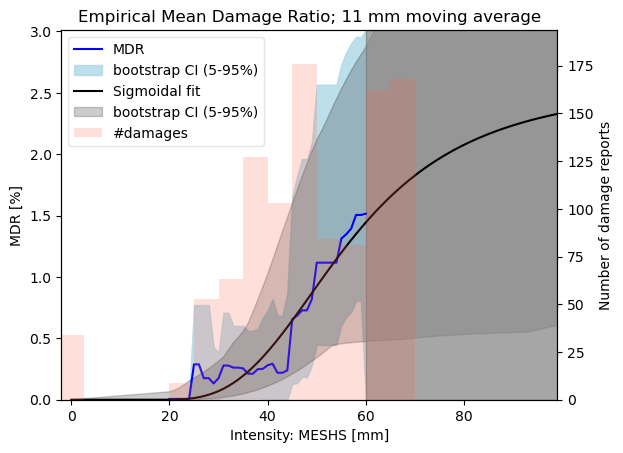

In [10]:
# plot rolling MDR
dmg_bin_size=sc.constants.DMG_BIN_DICT[haz_var]
title=f'Empirical Mean Damage Ratio; {unit_windowsize} {unit} moving average'

# MDR plot
fig,ax=sc.impf_plot2(df_all,df_roll,df_roll_cut,ds_boot_roll,ds_boot_roll_cut,
                     haz_var,impf_emanuel,cut_off,'MDR',title,dmg_bin_size,
                     intensity_label,color='blue',df_boot_emanuel=df_boot_emanuel)

In [11]:
intensity = np.arange(0, 100, 1)

df_impf = pd.DataFrame(index=intensity, columns=['PAA', 'MDD', 'MDR'])
for var in ['PAA', 'MDD', 'MDR']:
    df_impf.loc[1:, var] = df_roll[var].loc[intensity_range[1:]]

    # add smoothed function
    smooth = sc.smooth_monotonic(
        df_roll_cut.index[1:], df_roll_cut[var].loc[intensity_range[1:]])
    # plt.plot(df_roll_cut.index[1:],smooth)

    df_impf.loc[intensity_range[1]:, var+'_smooth'] = smooth

#add Sigmoidal function fit
np.testing.assert_array_equal(impf_emanuelPAA.intensity,intensity_range)
df_impf.loc[intensity_range[1:], 'PAA_emanuel'] = impf_emanuelPAA.mdd[1:]
df_impf.loc[intensity_range[1:], 'MDR_emanuel'] = impf_emanuel.mdd[1:]
df_impf.loc[intensity_range[1:], 'MDD_emanuel'] = impf_emanuelMDD.mdd[1:]

# set values above cut_off to values at cut_off
cut_vars = ['PAA', 'MDD', 'MDR']
if haz_var == 'MESHS':  # cut off at 59 instead of 60 for realistic values
    df_impf.loc[cut_off-1:,
                cut_vars] = df_impf.loc[cut_off-1, cut_vars].values
elif haz_var != 'POH': # for POH there is no cut off!
    df_impf.loc[cut_off:, cut_vars] = df_impf.loc[cut_off, cut_vars].values

#Save impact function data as .csv file
df_impf.fillna(0).to_csv(
    data_dir+'/temp/test_impf.csv')

## Step 4: Load impact function and calculate modelled impacts
relevant code from *hail_main.py*

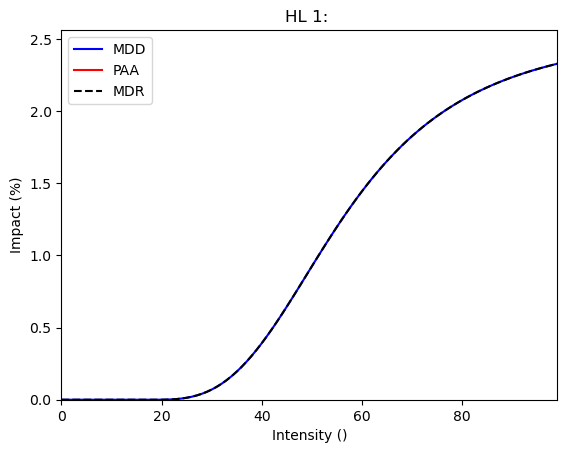

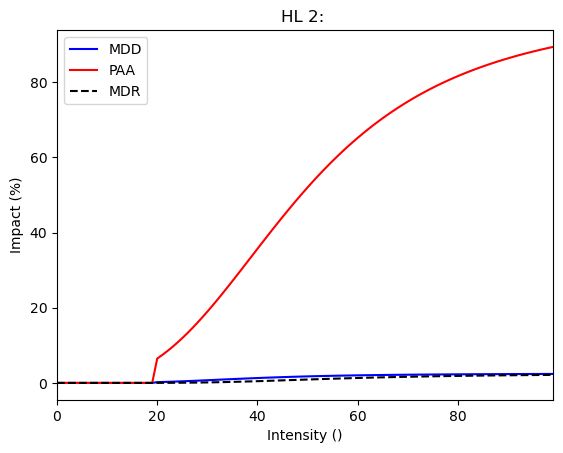

In [12]:
impf_path = data_dir+'/temp/test_impf.csv'
imp_fun_set = sc.impf_from_csv(impf_path, smooth=False,
                                emanuel_fit=True, plot=True)

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

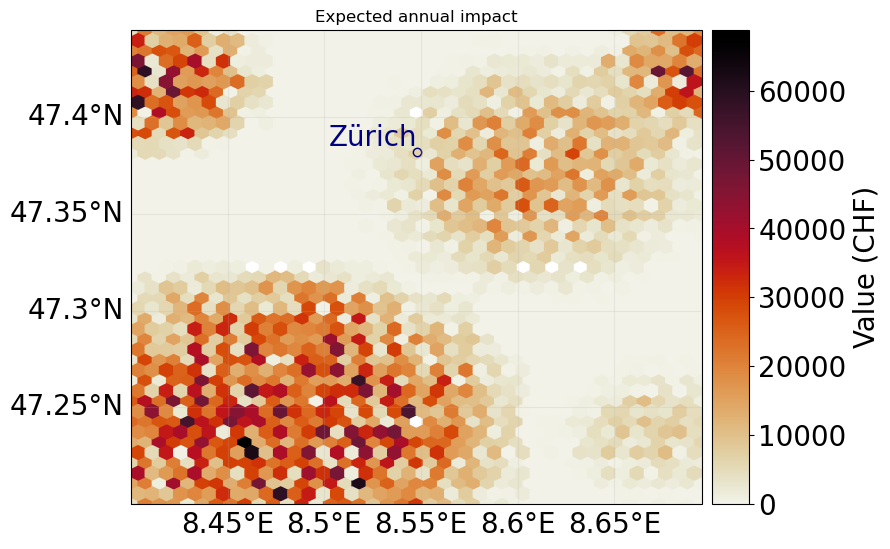

In [13]:
imp = ImpactCalc(exp, imp_fun_set, haz).impact(save_mat=True)
imp.plot_hexbin_eai_exposure(ignore_zero=False, gridsize=40)

## Step 5: Compare modelled and observed damages
relevant code from *hail_main.py*

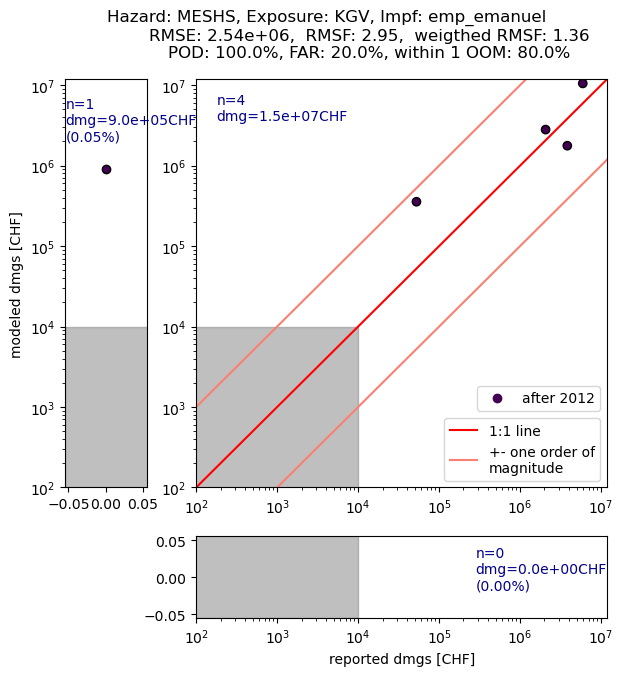

In [14]:
dmg_thresh = 1e4
imp_now=imp
imp_obs_now = imp_measured
xmin=1e2
#Impf type: Emprirically calibrated function in the form of Emanuel (2011)
impf = 'emp_emanuel'

#create impact dataframe with modelled and reported impacts per event (day)
#get all dates with modelled OR reported damages above xmin
ord_dates_nonZero = np.sort(np.unique(np.concatenate((imp_now.date[imp_now.at_event>xmin],
                                                      imp_obs_now.date[imp_obs_now.at_event>xmin]))))
imp_df = pd.DataFrame(index=ord_dates_nonZero,data={
    'date':[dt.datetime.fromordinal(d) for d in ord_dates_nonZero],
    "prePost2012":[dt.datetime.fromordinal(d).year>2012 for d in ord_dates_nonZero]})

imp_dfMod = pd.DataFrame(data={"imp_modelled":imp_now.at_event},index = imp_now.date)
imp_dfObs = pd.DataFrame(data={"imp_obs":imp_obs_now.at_event},index = imp_obs_now.date)

imp_df= imp_df.join(imp_dfMod,how='left') #join on index
imp_df= imp_df.join(imp_dfObs,how='left') #join on index
imp_df = imp_df.fillna(0) #fill NaN with zeros (for days with no reported or modelled damages)


#caculate skill scores
rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(imp_df,dmg_thresh)

#create dictionary with evaluation metrics to pass to plotting function
eval_dict = {var_name: globals()[var_name] for var_name in ["rmse","rmsf","rmsf_weighted",
            "FAR","POD","p_within_OOM","n_ev","haz_var","exposure","impf"]}

#plot scatter plot
fig = sc.plot_funcs.scatter_from_imp_df(imp_df,imp_now.unit,xmin,dmg_thresh,eval_dict)

Text(0.5, 1.0, 'Observed impact: 2021-06-15')

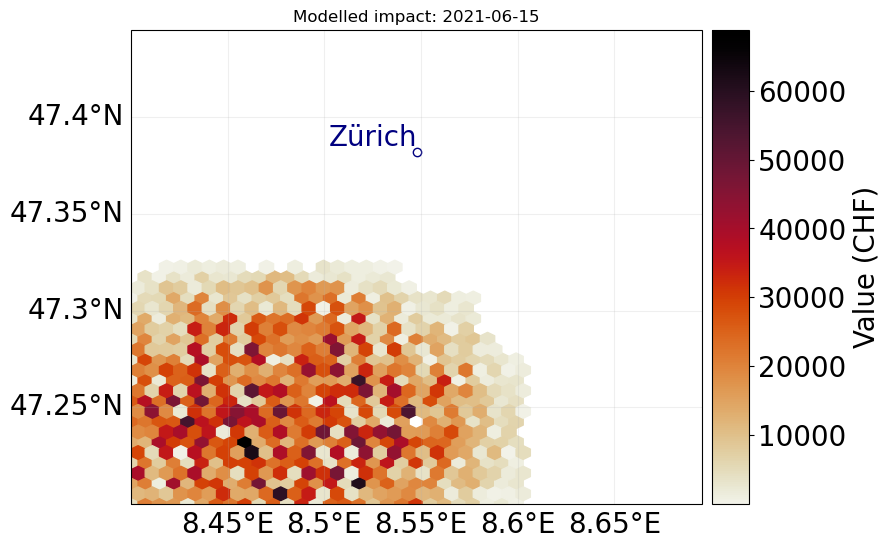

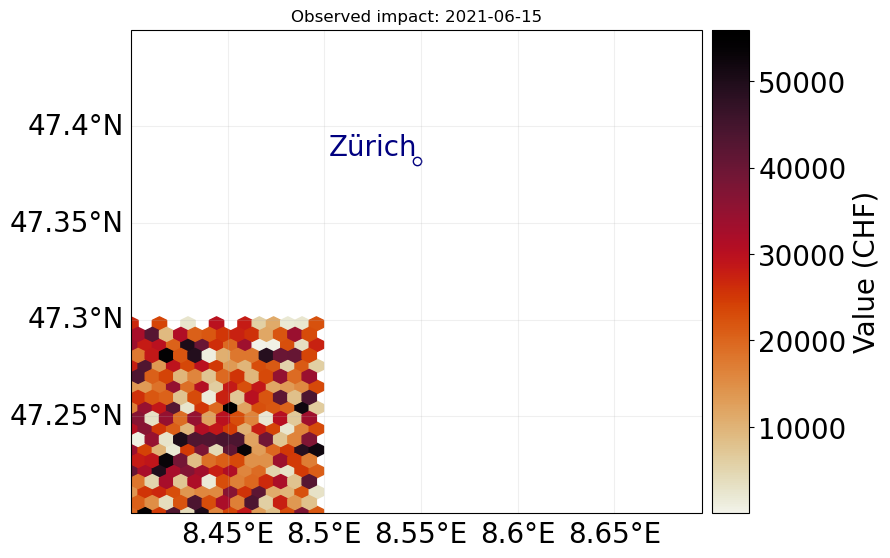

In [15]:
#Compare individual event
date = dt.datetime(2021,6,15).toordinal()
ax=imp.plot_hexbin_impact_exposure(imp.event_id[imp.date==date], gridsize=40,vmin=1)
ax.set_title(f'Modelled impact: {dt.datetime.fromordinal(date).strftime("%Y-%m-%d")}')
ax=imp_measured.plot_hexbin_impact_exposure(imp_measured.event_id[imp_measured.date==date], gridsize=40,vmin=1)
ax.set_title(f'Observed impact: {dt.datetime.fromordinal(date).strftime("%Y-%m-%d")}')